In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pylab as plt

## Load data

In [2]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
# y_test = np.load("y_test.npy")

In [3]:
# 7000 data with 300 features
print(x_train.shape)

(7000, 300)


In [4]:
# It's a binary classification problem
print(np.unique(y_train))

[0 1]


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [5]:
seed = 100

In [6]:
def cross_validation(x_train, y_train, k=5):
    X = np.arange(len(x_train))
    np.random.seed(seed)
    np.random.shuffle(X)
    kfold_data = []

    tmp = len(X) % k
    s1 = 0
    idx_list = []

    for i in range(k):
        l = len(X) // k
        if i < tmp:
            l += 1
        s2 = s1 + l
        idx_list.append((s1, s2))
        s1 += l

    for s1, s2 in idx_list:
        indices = list(range(0, s1)) + list(range(s2, len(X)))
        kfold_data.append([X[indices], X[range(s1, s2)]])

    return kfold_data

In [7]:
kfold_data = cross_validation(x_train, y_train, k=10)
assert len(kfold_data) == 10  # should contain 10 fold of data
# each element should contain train fold and validation fold
assert len(kfold_data[0]) == 2
# The number of data in each validation fold should equal to training data divieded by K
assert kfold_data[0][1].shape[0] == 700

In [8]:
for train_index, val_index in kfold_data:
    print(f'{len(train_index)}, {len(val_index)}')

6300, 700
6300, 700
6300, 700
6300, 700
6300, 700
6300, 700
6300, 700
6300, 700
6300, 700
6300, 700


In [9]:
print(kfold_data[0])

[array([6926, 5217, 1246, ..., 5955, 6936, 5640]), array([  49, 5774, 5013, 4839,  261,  344, 2589, 1021, 4751, 4039, 3931,
        535, 5581, 2242, 4696, 4122, 6799,  625, 5551, 3144, 4081, 4505,
        983, 5637, 2695, 2050, 1113, 3613, 3651, 6442, 3297, 2369, 6348,
       1405, 6747, 3351, 1711, 3313, 6811, 4477, 4375, 4541, 3851, 1200,
        153, 3259, 1378, 2230, 3542,  567, 4498, 1800, 1911, 4049, 1185,
        965, 3638, 1596, 5525, 3216, 3350, 6500, 1072, 3274, 3863, 6334,
       5242, 1994, 6598, 1607,  887, 2558, 3805,  472, 6585, 6827, 5281,
       4664, 6536, 2743, 6632, 5435, 3672, 6713, 5619, 4681, 5874, 6719,
       1791, 1300, 4087, 4306, 1474,  646, 4080, 3633, 3840, 3803, 6732,
       4567,  621, 3376,  349, 5162, 1055,  595,  785, 6202, 4984,   61,
       6715, 6513, 1760, 5750,  133, 5734, 1231, 1171, 3744, 5661, 3066,
       6781, 3759, 1162,  781, 5327, 1330, 1835, 2845, 4084, 1981, 3649,
       4583,  108, 4487,  116, 6688, 6269, 6249, 5495,  538,  585, 5966,


## example

In [10]:
from sklearn.model_selection import KFold

X = np.arange(20)
kf = KFold(n_splits=5, shuffle=True)
kfold_data = []
for i, (train_index, val_index) in enumerate(kf.split(X)):
    print("Split: %s, Training index: %s, Validation index: %s" %
          (i+1, train_index, val_index))
    kfold_data.append([train_index, val_index])

Split: 1, Training index: [ 1  2  3  4  5  6  7  8 10 11 12 13 15 16 18 19], Validation index: [ 0  9 14 17]
Split: 2, Training index: [ 0  1  2  4  5  7  8  9 10 11 12 14 15 17 18 19], Validation index: [ 3  6 13 16]
Split: 3, Training index: [ 0  1  3  4  5  6  7  9 11 12 13 14 15 16 17 19], Validation index: [ 2  8 10 18]
Split: 4, Training index: [ 0  1  2  3  6  7  8  9 10 13 14 15 16 17 18 19], Validation index: [ 4  5 11 12]
Split: 5, Training index: [ 0  2  3  4  5  6  8  9 10 11 12 13 14 16 17 18], Validation index: [ 1  7 15 19]


In [11]:
assert len(kfold_data) == 5  # should contain 5 fold of data
# each element should contains index of training fold and validation fold
assert len(kfold_data[0]) == 2
# The number of data in each validation fold should equal to training data divieded by K
assert kfold_data[0][1].shape[0] == 4

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C” and “gamma” to find the best parameters by cross-validation.

In [12]:
clf = SVC(C=1.0, kernel='rbf', gamma=0.01)

In [13]:
# your code
k = 5
kfold_data = cross_validation(x_train, y_train, k=k)
best_score, best_parameters = 0, dict(C=None, gamma=None)
c_param, gamma_param = [], []
score = []
for c_exp in range(0, 4):
    c_param.append(10 ** c_exp)
for gamma_exp in range(-5, -2):
    gamma_param.append(10 ** gamma_exp)

for C in c_param:
    tmp = []

    for gamma in gamma_param:
        avg_val_score = 0

        for train_index, val_index in kfold_data:
            clf = SVC(C=C, kernel='rbf', gamma=gamma)
            clf.fit(x_train[train_index], y_train[train_index])
            y_pred = clf.predict(x_train[val_index])

            avg_val_score += accuracy_score(y_train[val_index], y_pred)

        avg_val_score /= k
        tmp.append(avg_val_score)

        print(f'C: {C}  gamma: {gamma} Val acc: {avg_val_score}')
        if avg_val_score > best_score:
            best_score = avg_val_score
            best_parameters = dict(C=C, gamma=gamma)

    score.append(tmp)

C: 1  gamma: 1e-05 Val acc: 0.9541428571428572
C: 1  gamma: 0.0001 Val acc: 0.9931428571428572
C: 1  gamma: 0.001 Val acc: 0.5651428571428572
C: 10  gamma: 1e-05 Val acc: 0.9841428571428571
C: 10  gamma: 0.0001 Val acc: 0.9932857142857143
C: 10  gamma: 0.001 Val acc: 0.5637142857142857
C: 100  gamma: 1e-05 Val acc: 0.9911428571428571
C: 100  gamma: 0.0001 Val acc: 0.9932857142857143
C: 100  gamma: 0.001 Val acc: 0.5637142857142857
C: 1000  gamma: 1e-05 Val acc: 0.9914285714285714
C: 1000  gamma: 0.0001 Val acc: 0.9932857142857143
C: 1000  gamma: 0.001 Val acc: 0.5637142857142857


In [14]:
print(best_parameters)

{'C': 10, 'gamma': 0.0001}


In [15]:
print(c_param)
print(gamma_param)
print(np.array(score).shape)

[1, 10, 100, 1000]
[1e-05, 0.0001, 0.001]
(4, 3)


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like this reference image below ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

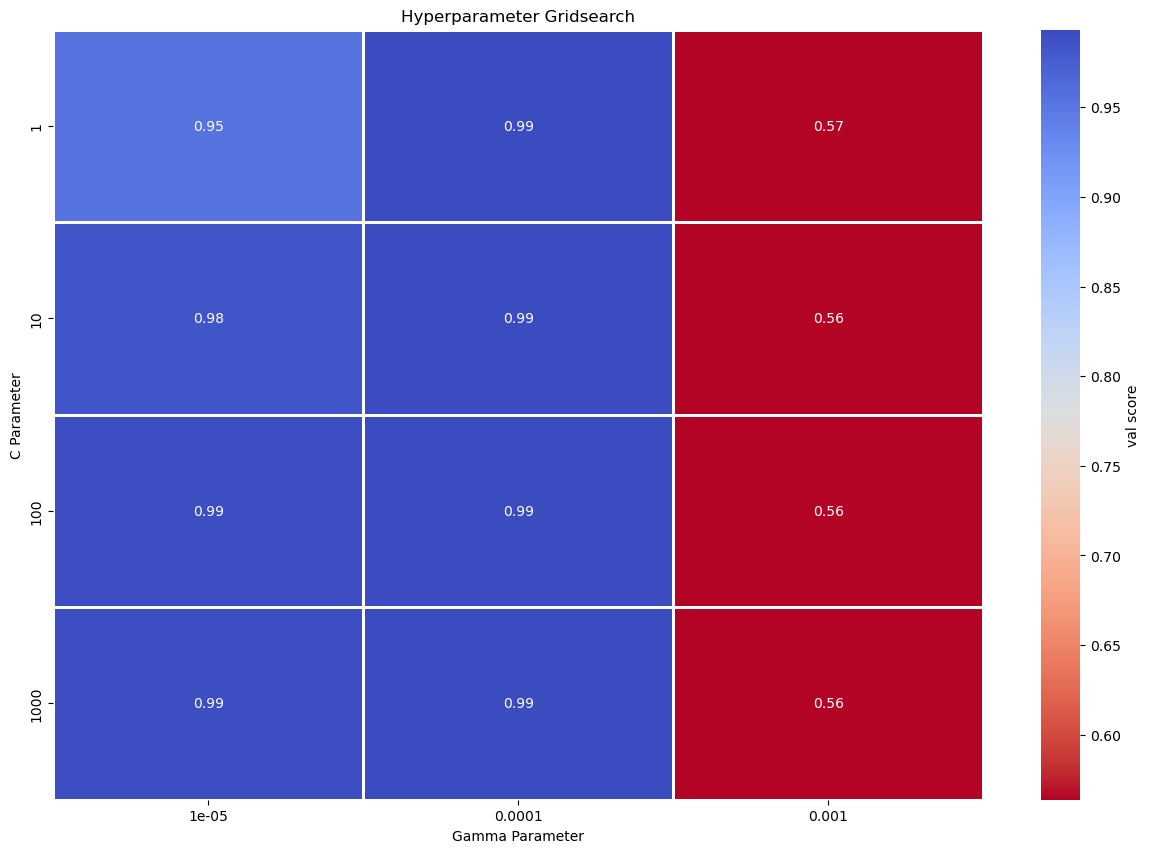

In [16]:
plt.figure(figsize=(15, 10))
ax = sns.heatmap(score,
                 annot=True,
                 xticklabels=gamma_param,
                 yticklabels=c_param,
                 linewidths=1.0,
                 cmap='coolwarm_r',
                 cbar_kws={'label': 'val score'})
plt.xlabel("Gamma Parameter")
plt.ylabel("C Parameter")
plt.title("Hyperparameter Gridsearch")
plt.show()

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set.

In [17]:
C, gamma = 10, 0.0001
best_model = SVC(C=C, kernel='rbf', gamma=gamma)
best_model.fit(x_train, y_train)
y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))

NameError: name 'y_test' is not defined